## replicate tops cross validation pipeline

Model selection in the tops paper used multiple criterias to test for 
* model sensitivity (CV)
* model specificity (CV)

in 2 datasets
* test dataset of study 1 (the original dataset used to train the model)
* an independent dataset with identical aqcuisition to study1

then summarised all these metrics into a single metric to determine the best fit model.

### load dcc matrix and ratings

In [194]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
dat = pickle.load(open('study3_reduced.p','rb'))

study 3 has 4 sets of data with 48 subjects:
* capsaicin pain (CAPS)
* control with no pain (REST)
* quinine aversive taste (QUIN)
* aversive odor (ODOR)

The pain/aversive ratings and DCC functional connectivity matrices were provided by the authors. For computing efficency, the matrices were reduced (downsampled every 10 values).

In [4]:
data = {}
for key, item in dat.items():
    dat_tmp = item
    for key_cond, item_cond in item.items():
#         print(key, key_cond)
        data[key+'_'+key_cond] = np.array(item_cond)

In [5]:
data['pain_REST'].shape

(48, 10)

Plotting ratings from 4 datasets

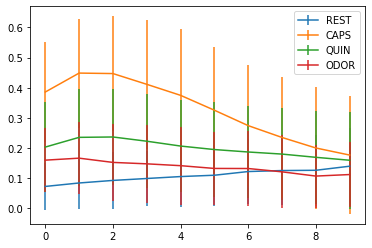

In [6]:
conds = ['REST', 'CAPS', 'QUIN', 'ODOR']
for c in conds:
    key = 'pain_'+c
    _ = plt.errorbar(np.arange(0,10), np.mean(data[key],axis=0), np.std(data[key],axis=0), label=c)
plt.legend()

### model training
we use half the subjects (n=24) for training, leaving the rest for testing (pretending it's a validation study like study 2). Like in the paper, we train with CAPS and REST conditions by concatenating them.

In [7]:
data_train = {}
data_test = {}
for key, item in data.items():
    data_train[key] = item[:24,:]
    data_test[key] = item[24:,:]

In [8]:
data['dcc_reduced_REST'].shape

(48, 388, 10)

In [9]:
data_train['dcc_reduced_REST'].shape

(24, 388, 10)

In [106]:
# combining CAPS and REST (study1)
data1 = {}
data1['dcc'] = np.concatenate([data_train['dcc_reduced_CAPS'],data_train['dcc_reduced_REST']], axis=2)
data1['rate'] = np.concatenate([data_train['pain_CAPS'],data_train['pain_REST']], axis=1)

In [107]:
# combining CAPS and REST (study2)
data2 = {}
data2['dcc'] = np.concatenate([data_test['dcc_reduced_CAPS'],data_test['dcc_reduced_REST']], axis=2)
data2['rate'] = np.concatenate([data_test['pain_CAPS'],data_test['pain_REST']], axis=1)

In [108]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [109]:
# reshape all subjects
sj_num = data1['dcc'].shape[0]
dcc_num = data1['dcc'].shape[1]
timebin_num = data1['dcc'].shape[2]
dcc = data1['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data1['rate'].reshape(sj_num*timebin_num)

* connectome based predictive modelling (CPM) - calculate correlate coefficient of each dcc component with ratings, separating into positive and negative, then sum over positive and negative dccs into two features to use in a linear regression. Hyperparameter to tune is the correlation threshold.

In [184]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

#     assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"
    assert train_vcts.shape[0]==train_behav.shape[0]

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)
    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [185]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

#     assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"
    assert train_vcts.shape[0]==train_behav.shape[0]

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items(): # iterate both positive and negative correlated components
#         X = train_vcts.values[:, mask].sum(axis=1) 
        X = train_vcts[:, mask].sum(axis=1)
        print(X.shape)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1) # X is a column, linear regression
        model_dict[tail] = (slope, intercept)
        t+=1
    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])] # regress with pos, neg, and constant
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [186]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
#         X = test_vcts.loc[:, mask].sum(axis=1)
        X = test_vcts[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

In [187]:
# calculate feature mask (hyperparameter is r_thresh 0-1)
mask = select_features(dcc.T, rate, r_thresh=0.2, corr_type='pearson')
# linear regression with pos, neg and constant
model_dict = build_model(dcc.T, mask, rate)
# predicting rating using model above
y_pred_cpm = apply_model(dcc.T, mask, model_dict)

(480,)
(480,)


Text(0.5, 1.0, 'CPM with correlation threshold 0.2, corrcoef=0.771')

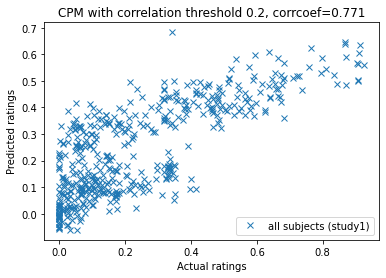

In [177]:
plt.plot(rate, y_pred_cpm['glm'],'x', label='all subjects (study1)')
plt.legend()
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
cc = np.corrcoef(rate, y_pred_cpm['glm'])[0,1]
plt.title(f'CPM with correlation threshold 0.2, corrcoef={cc:.3f}')

* Principal components regression (PCR) - linear regression with PCA components. Hyperparameter to tune is the number of PCs.

In [ ]:
# PCA for all subjects (do this once only for each model)
# load the helper functions at the end of notebook before running this
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [119]:
# how it's done in all subject without CV
# regression model
X = dcc_pca
y = rate
regr = linear_model.LinearRegression()
regr.fit(X, y)
# make predictions
y_pred = regr.predict(X)
# calculate correlation
np.corrcoef(y, y_pred)
# get weights
w1 = regr.coef_
print(w1.shape)

(15,)


Text(0.5, 1.0, 'PCR with 15 PCs, corrcoef=0.742')

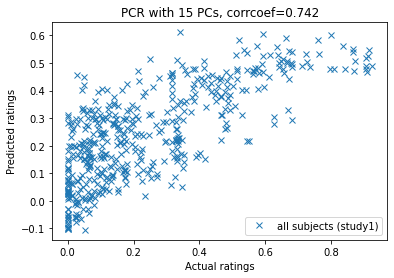

In [120]:
plt.plot(y,y_pred,'x', label='all subjects (study1)')
plt.legend()
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title(f'PCR with 15 PCs, corrcoef={np.corrcoef(y, y_pred)[0,1]:.3f}')

* PCR-lasso - a modification of linear regression. The loss function is modified to minimise the complexity of the model by limiting the sum of absolute values of model coefficients. Hyperparameters are the number of PCs and the Lasso parameter alpha.

In [126]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X, y) 
y_pred_lasso = model_lasso.predict(X)

Text(0.5, 1.0, 'PCR-Lasso with 15 PCs, corrcoef=0.709')

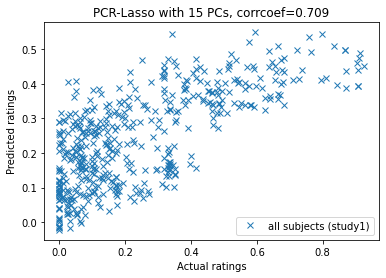

In [127]:
plt.plot(y,y_pred_lasso,'x', label='all subjects (study1)')
plt.legend()
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title(f'PCR-Lasso with 15 PCs, corrcoef={np.corrcoef(y, y_pred_lasso)[0,1]:.3f}')

### Criterion 1: within-individual prediction (study1)

Calculate Pearson's correlation values between actual and predicted ratings for each participant, then average the correlation coefficients to obtain 1 value per model.

In [225]:
def criterion1(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # leave one subject out CV
    corr_coefs_c1 = np.empty((sj_num,))
    color=iter(cm.rainbow(np.linspace(0,1,100)))
    for sj in range(sj_num):
        test_idx = np.arange(sj*timebin_num,(sj+1)*timebin_num)
        train_idx = np.concatenate([np.arange(0,sj*timebin_num), 
                                    np.arange((sj+1)*timebin_num, sj_num*timebin_num)])
        y_test = rate[test_idx]
        X_test = dcc_pca[test_idx, :]
        y_train = rate[train_idx]
        X_train = dcc_pca[train_idx, :]
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
        # calculate correlation
        corr_coefs_c1[sj] = np.corrcoef(y_test, y_pred)[0,1]
    return corr_coefs_c1

In [226]:
# calculate
corr_coefs_c1 = criterion1(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean CV within subject correlation
print(np.mean(corr_coefs_c1))
s1 = np.mean(corr_coefs_c1)

0.7462057798007957


### Criterion 2: between-individual prediction in study1
Calculate Pearson's correlation between averaged actual and predicted pain ratings for each condition across subject (1 subject has 2 ratings, CAPS and REST).

In [21]:
def average_n_rows(array_in, row_num):
    if len(array_in.shape)<2 or array_in.shape[1]==1: # col
        array_out = array_in.transpose().reshape(-1,row_num).mean(1).reshape(-1).transpose()
    else:
        col_num = array_in.shape[1]
        array_out = array_in.transpose().reshape(-1,row_num).mean(1).reshape(col_num,-1).transpose()        
    return array_out

In [22]:
def criterion2(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # leave one subject out CV
    corr_coefs_c2 = np.empty((sj_num,))
    for sj in range(sj_num):
        test_idx = np.arange(sj*timebin_num,(sj+1)*timebin_num)
        train_idx = np.concatenate([np.arange(0,sj*timebin_num), 
                                    np.arange((sj+1)*timebin_num, sj_num*timebin_num)])
        # mean within condition
        y_test_tmp = rate[test_idx]
        X_test_tmp = dcc_pca[test_idx, :]
        y_test = average_n_rows(y_test_tmp, int(timebin_num/2))
        X_test = average_n_rows(X_test_tmp, int(timebin_num/2))
        y_train_tmp = rate[train_idx]
        X_train_tmp = dcc_pca[train_idx, :]
        y_train = average_n_rows(y_train_tmp, int(timebin_num/2))
        X_train = average_n_rows(X_train_tmp, int(timebin_num/2))
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
#         print(y_pred, y_test)
        # calculate correlation
        corr_coefs_c2[sj] = np.corrcoef(y_test, y_pred)[0,1]
#         print(np.corrcoef(y_test, y_pred))
    return corr_coefs_c2

In [23]:
# calculate
corr_coefs_c2 = criterion2(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean CV across subject correlation (2 data points left, corrcoef 1 or -1)
s2 = np.mean(corr_coefs_c2)
print(s2)

1.0


### Criterion 3: classification of capsaicin vs control in study1
2 alternative forced choice classification, compare paired values (1 CAPS and 1 REST predicted value, CAPS should be larger than REST) for each individual.

In [24]:
def criterion3(dcc_pca, rate, sj_num, timebin_num, dcc_num):
    # leave one subject out CV
    correct_percent_c3 = np.empty((sj_num,))
    for sj in range(sj_num):
        test_idx = np.arange(sj*timebin_num,(sj+1)*timebin_num)
        train_idx = np.concatenate([np.arange(0,sj*timebin_num), 
                                    np.arange((sj+1)*timebin_num, sj_num*timebin_num)])
        # mean within condition
        y_test_tmp = rate[test_idx]
        X_test_tmp = dcc_pca[test_idx, :]
        y_test = average_n_rows(y_test_tmp, int(timebin_num/2))
        X_test = average_n_rows(X_test_tmp, int(timebin_num/2))
        y_train_tmp = rate[train_idx]
        X_train_tmp = dcc_pca[train_idx, :]
        y_train = average_n_rows(y_train_tmp, int(timebin_num/2))
        X_train = average_n_rows(X_train_tmp, int(timebin_num/2))
        # regression model
        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        # make predictions
        y_pred = regr.predict(X_test)
#         calculate correct percentage
#         print(y_pred)
        if y_pred[0]>y_pred[1]: # CAPS>REST
            correct_percent_c3[sj] = 1
    return correct_percent_c3

In [26]:
# calculate correct percentage
correct_percent_c3 = criterion3(dcc_pca, rate, sj_num, timebin_num, dcc_num)
# mean
print(np.mean(correct_percent_c3))
s3 = np.mean(correct_percent_c3)

1.0


### Criterion 4: within individual prediction in study2
Similar to model 1, but using a new dataset (not used CV in the paper)

In [72]:
# reshape all subjects
sj_num = data2['dcc'].shape[0]
dcc_num = data2['dcc'].shape[1]
timebin_num = data2['dcc'].shape[2]
dcc = data2['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data2['rate'].reshape(sj_num*timebin_num)
# PCA for all subjects (do this once only for each model)
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [73]:
# applying weights from 1 to study2 data
X = dcc_pca
y_pred = np.dot(X, w1)

In [74]:
# correlation coefficient
corr_coefs_c4 = np.corrcoef(rate, y_pred)[0,1]
s4 = corr_coefs_c4
print(s4)

0.12761027769481476


### Criterion 5: between-subject prediction in study2
similar to criterion 2, but using data from study 2 (no CV)

In [75]:
# applying weights to study 2 data
y_tmp = rate
X_tmp = dcc_pca
y = average_n_rows(y_tmp, int(timebin_num/2))
X = average_n_rows(X_tmp, int(timebin_num/2))
y_pred = np.dot(X, w1)

In [76]:
# correlation coefficient
corr_coefs_c5 = np.corrcoef(y, y_pred)[0,1]
s5 = corr_coefs_c5
print(s5)

0.14153238052651612


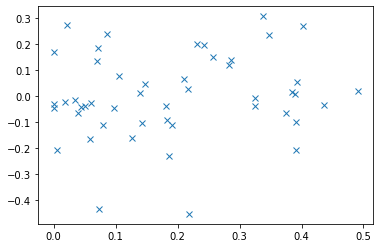

In [83]:
plt.plot(y, y_pred, 'x')

### Criterion 6: classification of capsaicin vs control in study2
similar to criterion 3, using study 2 data (no cv)

In [84]:
# applying weights to study 2 data
y_tmp = rate
X_tmp = dcc_pca
y = average_n_rows(y_tmp, int(timebin_num/2))
X = average_n_rows(X_tmp, int(timebin_num/2))
y_pred = np.dot(X, w1)

In [85]:
# separating in conditions
y_pred_CAPS = y_pred[::2]
y_pred_REST = y_pred[1::2]

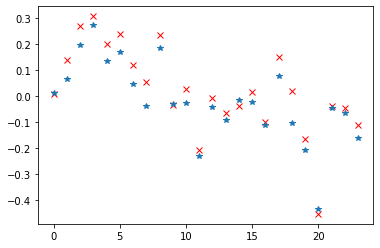

In [88]:
plt.plot(y_pred_CAPS, 'rx')
plt.plot(y_pred_REST, '*')

In [87]:
# calculating prediction accuracy
s6 = np.mean(y_pred_CAPS>y_pred_REST)
print(s6)

0.8333333333333334


### Criterion 7: classification of capsaicin vs quinine in study2
this examines the model specificity to see if it discriminates pain from non-painful aversive condition (quinine). Similar to 6, but comparing CAPS and QUIN.

In [89]:
# combining CAPS and QUIN (study2)
data2a = {}
data2a['dcc'] = np.concatenate([data_test['dcc_reduced_CAPS'],data_test['dcc_reduced_QUIN']], axis=2)
data2a['rate'] = np.concatenate([data_test['pain_CAPS'],data_test['pain_QUIN']], axis=1)

In [90]:
# reshape all subjects
sj_num = data2a['dcc'].shape[0]
dcc_num = data2a['dcc'].shape[1]
timebin_num = data2a['dcc'].shape[2]
dcc = data2a['dcc'].reshape((dcc_num, timebin_num*sj_num))
rate = data2a['rate'].reshape(sj_num*timebin_num)
# PCA for all subjects (do this once only for each model)
dcc_pca, evectors, evals = pca(dcc.T, n_components=15)

In [91]:
# applying weights to study 2 data
y_tmp = rate
X_tmp = dcc_pca
y = average_n_rows(y_tmp, int(timebin_num/2))
X = average_n_rows(X_tmp, int(timebin_num/2))
y_pred = np.dot(X, w1)

In [92]:
# separating in conditions
y_pred_CAPS = y_pred[::2]
y_pred_QUIN = y_pred[1::2]

In [93]:
# calculating prediction accuracy
s7 = np.mean(y_pred_CAPS>y_pred_QUIN)
print(s7)

0.20833333333333334


### Taking it all together
The final model performance score is calculated as:

$$ P_{i,j} = (S_{i,j}-minV_j) / (maxV_j-minV_j) * 100$$

where $S_{i,j}$ is the raw performance score for ith model and jth criterion. Vj is vectorised $S_{i,j}$ across models, and $P_{i,j}$ is the normalised score.

Therefore, for 279 brain parcellation, DCC correlation, PCR with 15 PCs, this particular model has final score of: 

In [94]:
s_ij = np.array([s1, s2, s3, s4, s5, s6, s7])

In [95]:
p_ij = (s_ij-min(s_ij))/(max(s_ij)-min(s_ij))*100
print(p_ij)
print(sum(p_ij))

[ 70.90816023 100.         100.           0.           1.59585819
  80.89538856   9.25309567]
362.65250265274534


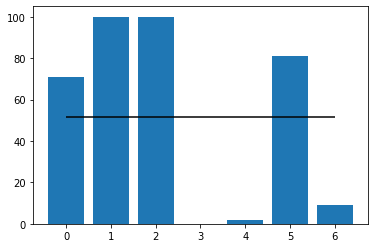

In [104]:
plt.bar(np.arange(len(p_ij)), p_ij)
plt.hlines(np.mean(p_ij), 0, 6,'k')

highest possible score will be 700, while this particular model has 362.

We can repeat the procedure for different parameters and find the best combination.

### the end

### helper functions

#### PCA

In [3]:
# reducing DCC_out to 21PC
def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    # Subtract the mean of X
    X = X - np.mean(X, 0)
    # Calculate the covariance matrix (hint: use np.matmul)
    cov_matrix =  1 / X.shape[0] * np.matmul(X.T, X)

    return cov_matrix

def sort_evals_descending(evals, evectors, n_components=None):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    if n_components is not None:
        index = index[:n_components]
    evals = evals[index]
    evectors = evectors[:, index]
#     if evals.shape[0] == 2:
#         if np.arccos(np.matmul(evectors[:, 0],
#                            1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2: evectors[:, 0] = -evectors[:, 0]
#         if np.arccos(np.matmul(evectors[:, 1],
#                            1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)
    return Y


def pca(X, n_components):
    """
    Performs PCA on multivariate data.
    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
    """

    # Subtract the mean of X
    X = X - np.mean(X, axis=0)
    # Calculate the sample covariance matrix
    cov_matrix = get_sample_cov_matrix(X)
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues in descending order
    evals, evectors = sort_evals_descending(evals, evectors, n_components)
    # Project the data onto the new eigenvector basis
    score = change_of_basis(X, evectors)

    return score, evectors, evals

#### reduce dcc matrix size

In [14]:
# helper functions to load mat
import scipy.io as spio
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [81]:
main_mat = './data/whole_participants/FC_and_pain/study3.mat'

In [82]:
m = loadmat(main_mat)

In [83]:
# reduce size of dcc
m['dcc_reduced'] = {}
for key, item in m['dcc'].items():
    print(key)
    tmp_ls = []
    for subj in range(len(item)):
        tmp_ls.append(item[subj][::100])
    m['dcc_reduced'][key] = tmp_ls

REST
CAPS
QUIN
ODOR


In [84]:
mr = {'dcc_reduced':m['dcc_reduced'], 'pain':m['pain']}

In [85]:
import pickle
pickle.dump(mr,open('study3_reduced.p','wb'))